# Assignment 06
Bill Henderson

CSCI-E-116

Spring 2025

### Imports

In [47]:
import yaml
from tabulate import tabulate
from fredapi import Fred
import datetime
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
from itertools import product
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
from typing import Union

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Part A. Running Three Models: VAR Level, VAR Growth and ARIMA 
## Data Collection

In [3]:
keys = yaml.safe_load(open('/Users/hendwi1/.env'))

fred = Fred(keys['fred_key'])
obs_start = "1986-02-01"
obs_end = "2025-1-31"

In [6]:
oil_price = fred.get_series("DCOILWTICO", observation_start=obs_start, observation_end=obs_end).resample('M').mean() # Oil price
nasdaq = fred.get_series("NASDAQCOM", observation_start=obs_start, observation_end=obs_end).resample('M').mean() # NASDAQ stock price
payroll = fred.get_series("PAYEMS", observation_start=obs_start, observation_end=obs_end).resample('M').mean() # Nonfarm payroll jobs
cpi = fred.get_series("CPILFESL", observation_start=obs_start, observation_end=obs_end).resample('M').mean() # Core Consumer Price Index
ffr = fred.get_series("DFF", observation_start=obs_start, observation_end=obs_end).resample('M').mean() # Federal Fund Rate

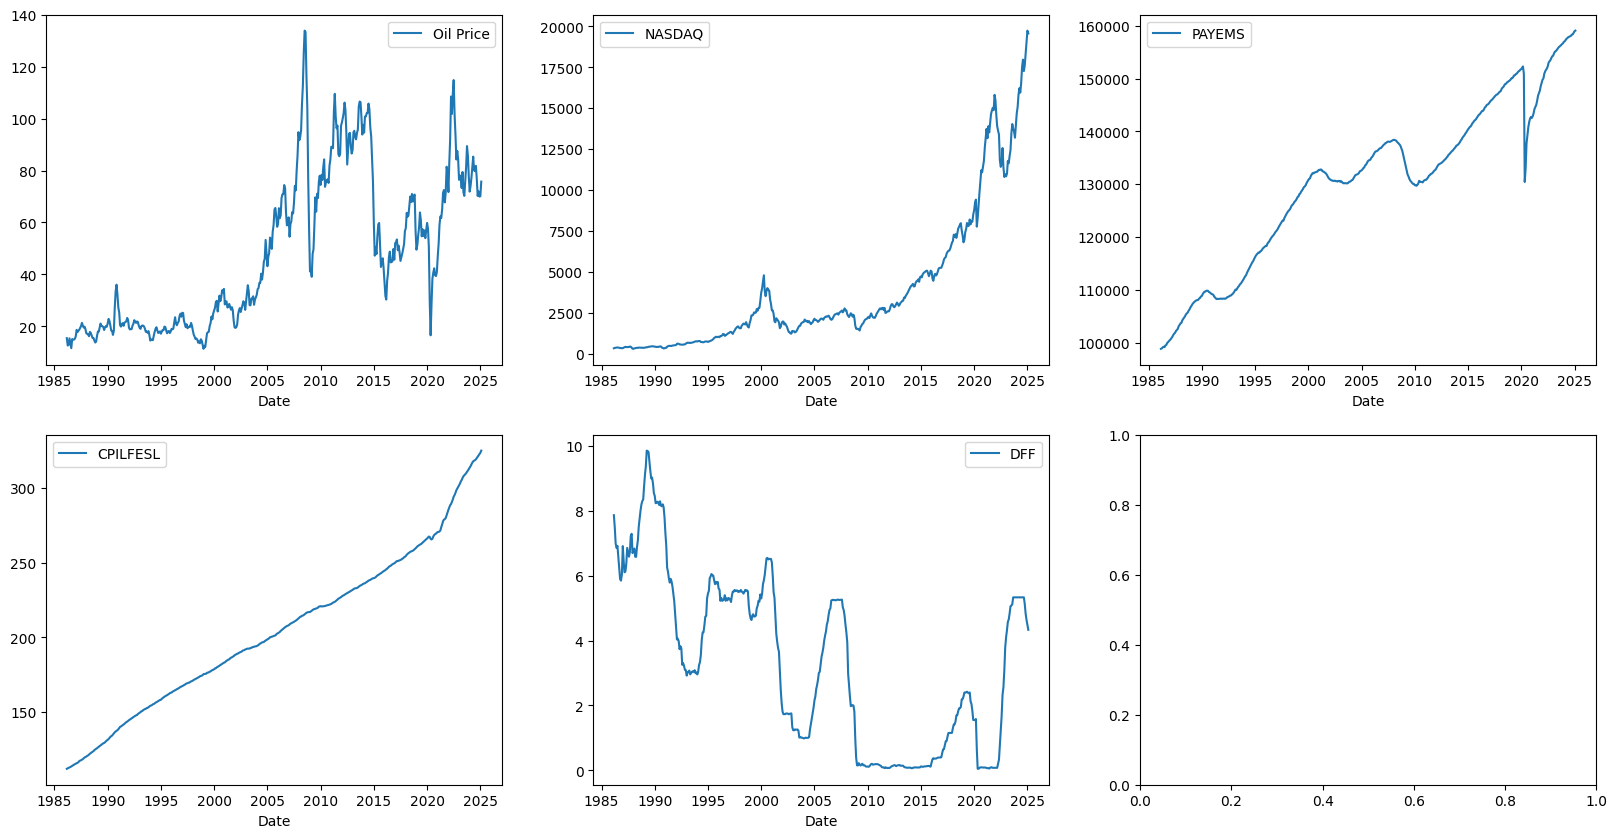

In [16]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
names = ["Oil Price", "NASDAQ","PAYEMS", "CPILFESL", "DFF"]
ax = ax.flatten()
for i, d in enumerate(zip(names,[oil_price, nasdaq, payroll, cpi, ffr])):
    sns.lineplot(data=d[1], ax=ax[i], label=d[0], )
    ax[i].set_xlabel("Date")
plt.show()

## Creating Data0 and Data1

In [36]:
data0_setup = {d[0].lower().replace(" ","_"): d[1] for d in zip(names,
                                                                [oil_price,
                                                                 nasdaq,
                                                                 payroll,
                                                                 cpi,
                                                                 ffr])}
data0 = pd.DataFrame(data_setup).dropna()


data1_setup = {d[0].lower().replace(" ","_"): d[1] for d in zip(names, 
                                                               [oil_price.apply(np.log).diff(), 
                                                                nasdaq.apply(np.log).diff(), 
                                                                payroll.apply(np.log).diff(), 
                                                                cpi.apply(np.log).diff(), 
                                                                ffr])}
data1 = pd.DataFrame(data1_setup).dropna()

## Create the train sets for the above two data frames 

In [50]:
start_train=(1986, 3)
end_train=datetime.datetime(2024,11,30)

train_data0 = data0[data0.index <= end_train]
train_data1 = data1[data1.index <= end_train]
print(f"Training Data\nFirst date: {train_data1.index.min()}\nLast date: {train_data1.index.max()}")

Training Data
First date: 1986-03-31 00:00:00
Last date: 2024-11-30 00:00:00


## Run two VAR models of these 5 variables

In [48]:
results ={"dataset":[], "stat":[], "adf_stat":[], "p_val":[],"lag":[]}
for ds_idx, data in enumerate([data0, data1]):  
    for d_name in data0_setup.keys():
        results['dataset'].append(ds_idx)
        results['stat'].append(d_name)
        af_result = adfuller(data[d_name], maxlag=15, autolag='AIC')
        results['adf_stat'].append(af_result[0])
        results['p_val'].append(af_result[1])
        results['lag'].append(af_result[2])
results_df = pd.DataFrame(results)

print(tabulate(results_df, headers='keys', tablefmt='psql'))

+----+-----------+-----------+------------+-------------+-------+
|    |   dataset | stat      |   adf_stat |       p_val |   lag |
|----+-----------+-----------+------------+-------------+-------|
|  0 |         0 | oil_price |  -11.9513  | 4.31154e-22 |     3 |
|  1 |         0 | nasdaq    |  -13.8909  | 5.97101e-26 |     1 |
|  2 |         0 | payems    |  -17.4217  | 4.82151e-30 |     1 |
|  3 |         0 | cpilfesl  |   -2.71079 | 0.0721905   |    12 |
|  4 |         0 | dff       |   -2.39796 | 0.142313    |    11 |
|  5 |         1 | oil_price |  -11.9513  | 4.31154e-22 |     3 |
|  6 |         1 | nasdaq    |  -13.8909  | 5.97101e-26 |     1 |
|  7 |         1 | payems    |  -17.4217  | 4.82151e-30 |     1 |
|  8 |         1 | cpilfesl  |   -2.71079 | 0.0721905   |    12 |
|  9 |         1 | dff       |   -2.39796 | 0.142313    |    11 |
+----+-----------+-----------+------------+-------------+-------+


In [62]:
def best_VAR_model(d, trend: str,  max_lag=15):
    endog = d.columns[:-1]
    exog = d.columns[-1]

    results = {}
    for lag in range(1,max_lag+1):
        try:
            r = VARMAX(
                endog=d[endog], 
                order=(lag, 0),
                exog=d[exog],
                trend=trend
            ).fit(dips=False)
        except:
            continue
        results[r.aic] = r
        print(f"lag: {lag}, aic: {r.aic}")
    min_aic = min(results.keys())
    print(f"Best AIC: {min_aic}")
    return results[min_aic]

In [ ]:
model0 = best_VAR_model(data0,'ct')

lag: 1, aic: -10860.165567156648
lag: 2, aic: -10868.073189509694
lag: 3, aic: -10855.44103517295
lag: 4, aic: -10845.344208030085
lag: 5, aic: -10837.58200041192
lag: 6, aic: -10829.657351119124
lag: 7, aic: -10820.833432731788
lag: 8, aic: -10813.092489139675
lag: 9, aic: -10795.83884428778
lag: 10, aic: -10784.413744772657
lag: 11, aic: -10773.971921391738


In [ ]:
model1 = best_VAR_model(data1,'c')